<a href="https://colab.research.google.com/github/Vipin8990/python-Datascience/blob/main/wildfire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jswlakvipin","key":"839c31973189d0a3d59ba783d7f068a3"}'}

In [2]:
!pip install -q kaggle

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d abdelghaniaaba/wildfire-prediction-dataset

100% 1.44G/1.45G [01:22<00:00, 22.3MB/s]
100% 1.45G/1.45G [01:22<00:00, 18.9MB/s]


In [5]:
!unzip /content/wildfire-prediction-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: valid/nowildfire/-73.465183,45.443641.jpg  
  inflating: valid/nowildfire/-73.465388,45.584881.jpg  
  inflating: valid/nowildfire/-73.469451,45.480331.jpg  
  inflating: valid/nowildfire/-73.471252,45.51974.jpg  
  inflating: valid/nowildfire/-73.472693,45.427766.jpg  
  inflating: valid/nowildfire/-73.473015,45.435254.jpg  
  inflating: valid/nowildfire/-73.475051,45.56612.jpg  
  inflating: valid/nowildfire/-73.477079,45.597274.jpg  
  inflating: valid/nowildfire/-73.478813,45.555686.jpg  
  inflating: valid/nowildfire/-73.479478,45.524618.jpg  
  inflating: valid/nowildfire/-73.480135,45.528248.jpg  
  inflating: valid/nowildfire/-73.480722,45.518864.jpg  
  inflating: valid/nowildfire/-73.481149,45.563113.jpg  
  inflating: valid/nowildfire/-73.481422,45.559789.jpg  
  inflating: valid/nowildfire/-73.481565,45.467244.jpg  
  inflating: valid/nowildfire/-73.483407,45.637554.jpg  
  inflating: valid/nowildfire/-73.48589

In [6]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [7]:
import tensorflow as tf

from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import numpy as np
import matplotlib.pyplot as plt

import cv2
import os
import pandas as pd

In [8]:
for device in tf.config.list_physical_devices():
    print(": {}".format(device.name))

: /physical_device:CPU:0
: /physical_device:GPU:0


In [9]:
# defining paths of train, validation and test data
train_path = "/content/train"
valid_path = "/content/valid"
test_path = "/content/test"

In [10]:
image_shape = (350,350,3)
N_CLASSES = 2
BATCH_SIZE = 256

# loading training data and rescaling it using ImageDataGenerator
train_datagen = ImageDataGenerator(dtype='float32', rescale= 1./255.)
train_generator = train_datagen.flow_from_directory(train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (350,350),
                                                   class_mode = 'categorical')

# loading validation data and rescaling it using ImageDataGenerator
valid_datagen = ImageDataGenerator(dtype='float32', rescale= 1./255.)
valid_generator = valid_datagen.flow_from_directory(valid_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (350,350),
                                                   class_mode = 'categorical')

# loading test data and rescaling it using ImageDataGenerator
test_datagen = ImageDataGenerator(dtype='float32', rescale = 1.0/255.0)
test_generator = test_datagen.flow_from_directory(test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (350,350),
                                                   class_mode = 'categorical')

Found 30250 images belonging to 2 classes.
Found 6300 images belonging to 2 classes.
Found 6300 images belonging to 2 classes.


In [11]:
# defining the coefficient that our regularizer will use
weight_decay = 1e-3

# building a sequential CNN model and adding layers to it
# dropout and the regularizer are used in general to prevent overfitting
first_model = Sequential([
    Conv2D(filters = 8 , kernel_size = 2, activation = 'relu',
    input_shape = image_shape), MaxPooling2D(pool_size = 2),

    Conv2D(filters = 16 , kernel_size = 2, activation = 'relu',
    input_shape = image_shape), MaxPooling2D(pool_size = 2),

    Conv2D(filters = 32 , kernel_size = 2, activation = 'relu',
           kernel_regularizer = regularizers.l2(weight_decay)),
    MaxPooling2D(pool_size = 2),

    Dropout(0.4),
    Flatten(),
    Dense(300,activation='relu'),
    Dropout(0.5),
    Dense(2,activation='softmax')
])
# showing the summary of our model (layers and number of parameters)
first_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 349, 349, 8)       104       
                                                                 
 max_pooling2d (MaxPooling2  (None, 174, 174, 8)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 173, 173, 16)      528       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 86, 86, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 85, 85, 32)        2080      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 42, 42, 32)        0

In [13]:
# don't stop everything if an image didn't load correctly
from PIL import ImageFile
import h5py
ImageFile.LOAD_TRUNCATED_IMAGES = True

# checkpointer to save the model only if it improved
from tensorflow.keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint('first_model.keras', verbose=1, save_best_only=True)

# early stopping to stop the training if our validation loss didn't decrease for (10) consecutive epochs
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor= 'val_loss', patience= 10)

# Adam, best optimiser for deep learning models to help with the training
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate= 0.00001)

# setting our loss function and which metric to evaluate
first_model.compile(loss= 'categorical_crossentropy', optimizer= optimizer,
                    metrics=['AUC','acc'])

# TRAIN
history = first_model.fit(train_generator,
                    epochs = 20,
                    verbose = 1,
                    validation_data = valid_generator,
                    callbacks = [checkpointer, early_stopping])

Epoch 1/20
119/119 [==============================] - ETA: 0s - loss: 0.2560 - auc: 0.9667 - acc: 0.9049
Epoch 1: val_loss improved from inf to 0.22653, saving model to first_model.keras
119/119 [==============================] - 175s 1s/step - loss: 0.2560 - auc: 0.9667 - acc: 0.9049 - val_loss: 0.2265 - val_auc: 0.9748 - val_acc: 0.9183
Epoch 2/20
119/119 [==============================] - ETA: 0s - loss: 0.2457 - auc: 0.9694 - acc: 0.9086
Epoch 2: val_loss improved from 0.22653 to 0.22162, saving model to first_model.keras
119/119 [==============================] - 173s 1s/step - loss: 0.2457 - auc: 0.9694 - acc: 0.9086 - val_loss: 0.2216 - val_auc: 0.9760 - val_acc: 0.9195
Epoch 3/20
119/119 [==============================] - ETA: 0s - loss: 0.2375 - auc: 0.9716 - acc: 0.9139
Epoch 3: val_loss improved from 0.22162 to 0.22091, saving model to first_model.keras
119/119 [==============================] - 173s 1s/step - loss: 0.2375 - auc: 0.9716 - acc: 0.9139 - val_loss: 0.2209 - val

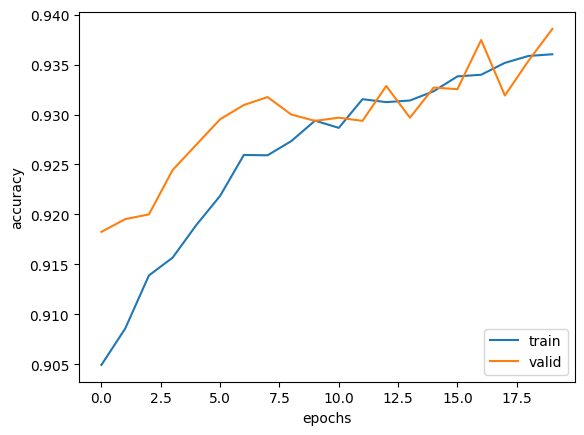

In [14]:
# add history of accuracy and validation accuracy to the plot
plt.plot(history.history['acc'], label = 'train',)
plt.plot(history.history['val_acc'], label = 'valid')

# adding legend and labels
plt.legend(loc = 'lower right')
plt.xlabel('epochs')
plt.ylabel('accuracy')

# show the plot
plt.show()

In [15]:
# see if it's good at predecting new inputs
result = first_model.evaluate(test_generator)

25/25 [==============================] - 28s 1s/step - loss: 0.1687 - auc: 0.9855 - acc: 0.9462
